In [179]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Stop TF from showing unnecessary deprecation warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

# sys.path.append('..') # this line is not needed if PyDEns is installed as package
from pydens import Solver, NumpySampler, cart_prod, add_tokens, plot_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
add_tokens()

Name `sin` already present in current namespace. Added as sin__
Name `cos` already present in current namespace. Added as cos__
Name `tan` already present in current namespace. Added as tan__
Name `asin` already present in current namespace. Added as asin__
Name `acos` already present in current namespace. Added as acos__
Name `atan` already present in current namespace. Added as atan__
Name `sinh` already present in current namespace. Added as sinh__
Name `cosh` already present in current namespace. Added as cosh__
Name `tanh` already present in current namespace. Added as tanh__
Name `asinh` already present in current namespace. Added as asinh__
Name `acosh` already present in current namespace. Added as acosh__
Name `atanh` already present in current namespace. Added as atanh__
Name `exp` already present in current namespace. Added as exp__
Name `log` already present in current namespace. Added as log__
Name `pow` already present in current namespace. Added as pow__
Name `sqrt` alre

## System of ODEs

Let's solve this system of ODEs via pydens 0.1.2, tensorflow 1.31.1 and Python 3.7.9

$$ \begin{cases} \frac{d m_1}{d t^*} = - \gamma (m_2 H_3 - H_2 \sqrt{1 - m_1^2 - m_2^2}) - \gamma \lambda (m_1 m_2 H_2 - H_1 + m_1^2 H_1 - m_1 H_3 \sqrt{1 - m_1^2 - m_2^2}) \\ \frac{d m_2}{d t^*} = - \gamma (H_1 \sqrt{1 - m_1^2 - m_2^2} - m_1 H_3) - \gamma \lambda (m_2 H_3 \sqrt{1 - m_1^2 - m_2^2} - H_2 + m_2^2 H_2 - m_1 m_2 H_1) \end{cases}, \quad m_1(0)=1, m_2(0)=0, m_3(0)=0 $$

In [181]:
(GAMMA, LAMBDA) = (1.5, 1.5)
(H1, H2, H3) = (0, 0, 1)

pde = {'n_dims': 1, 'n_funs': 3, 'n_eqns': 2,
       'form': [
              lambda m1, m2, m3, t: D(m1, t) + GAMMA*(m2*H3 - H2*sqrt(1 - m1**2 - m2**2)) + GAMMA*LAMBDA*(m1*m2*H2 - H1 + m1**2*H1 - m1*H3*sqrt(1 - m1**2 - m2**2)),
              lambda m1, m2, m3, t: D(m2, t) + GAMMA*(H1*sqrt(1 - m1**2 - m2**2) - m1*H3) + GAMMA*LAMBDA*(m2*H3*sqrt(1 - m1**2 - m2**2) - H2 + m2**2*H2 - m1*m2*H1),
       ],
       'initial_condition': [ [0.0], [0.0], [1.0] ],
       'time_multiplier': 'polynomial'}

# Put it all together in model-config
config = {'pde': pde}  

# Uniform sampling scheme
s = NumpySampler('u', dim=1)

In [182]:
# train the network
dg = Solver(config)
dg.fit(batch_size=250, sampler=s, n_iters=1000, bar='notebook')

  0%|          | 0/1000 [00:00<?, ?it/s]

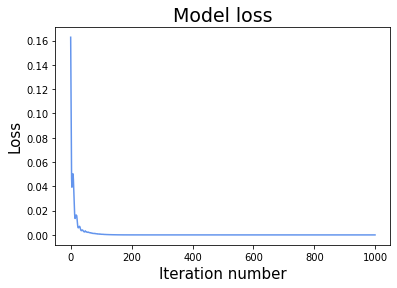

In [183]:
plot_loss(dg.loss, color='cornflowerblue')

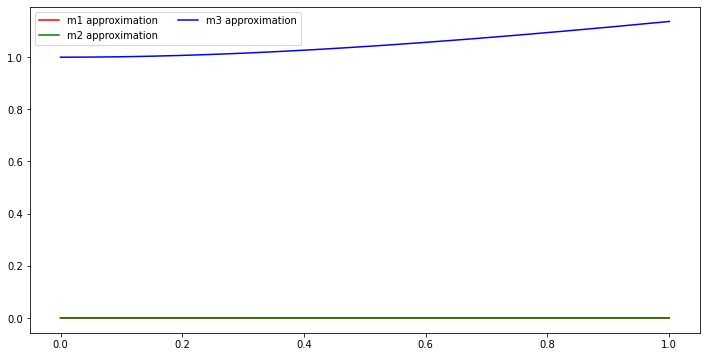

In [215]:
# Plot true solutions and their approximations
# t* [0;1]
n_el = 1000
pts = np.linspace(0, 1, n_el).reshape((n_el, 1))

approxs_1 = dg.solve(pts)[:, 0]
approxs_2 = dg.solve(pts)[:, 1]
approxs_3 = dg.solve(pts)[:, 2]

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pts, approxs_1.reshape(n_el, ), 'r', label='m1 approximation')
plt.plot(pts, approxs_2.reshape(n_el, ), 'g', label='m2 approximation')
plt.plot(pts, approxs_3.reshape(n_el, ), 'b', label='m3 approximation')
plt.legend(ncol=2)
fig.show()

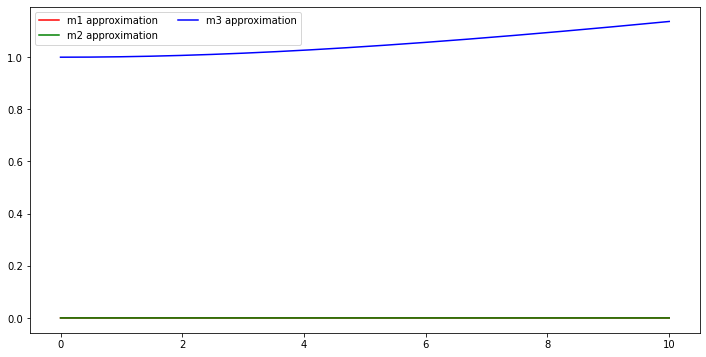

In [216]:
# Plot true solutions and their approximations
# t* [0;10]
pts = np.linspace(0, 10, n_el).reshape((n_el, 1))

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pts, approxs_1.reshape(n_el, ), 'r', label='m1 approximation')
plt.plot(pts, approxs_2.reshape(n_el, ), 'g', label='m2 approximation')
plt.plot(pts, approxs_3.reshape(n_el, ), 'b', label='m3 approximation')
plt.legend(ncol=2)
fig.show()

## Result verification via Scipy

In [224]:
from scipy import integrate

In [248]:
def system_of_odes(t, r):
    m1, m2, m3 = r
    dm1 = - GAMMA*(m2*H3 - m3*H2) - GAMMA*LAMBDA*(m1*m2*H2 - m2**2*H1 - m3**2*H1 - m1*m3*H3)
    dm2 = - GAMMA*(m3*H1 - m1*H3) - GAMMA*LAMBDA*(m2*m3*H3 - m3**2*H2 - m1**2*H2 - m1*m2*H1)
    dm3 = - GAMMA*(m1*H2 - m2*H1) - GAMMA*LAMBDA*(m1*m3*H1 - m1**2*H3 - m2**2*H2 - m2*m2*H2)
    return dm1, dm2, dm3

sol = integrate.solve_ivp(system_of_odes, (0, 10), (1, 0, 0), t_eval=np.linspace(0, 10, 1000))
m1, m2, m3 = sol.y

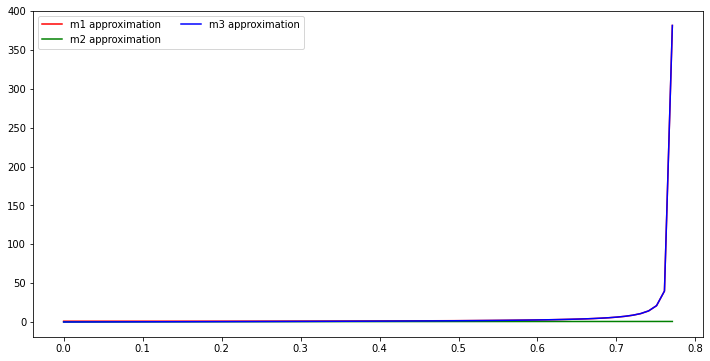

In [251]:
pts = sol.t #np.linspace(0, 10, len(m1))

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pts, m1, 'r', label='m1 approximation')
plt.plot(pts, m2, 'g', label='m2 approximation')
plt.plot(pts, m3, 'b', label='m3 approximation')
plt.legend(ncol=2)
fig.show()